In [37]:
import function.functions as functions

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import importlib

plt.rcParams['text.usetex'] = True
params = {
    "backend": "ps",
    "axes.labelsize": 22,
    "font.size": 22,
    "legend.fontsize": 10,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "legend.frameon": True,
    "savefig.dpi": 100,
    "axes.linewidth": 1.5,
    'xtick.major.size' : 10,
    'xtick.major.width': 1,
    'xtick.minor.size': 7,
    'xtick.minor.width': 1,
    'ytick.major.size' : 10,
    'ytick.major.width': 1,
    'ytick.minor.size': 7,
    'ytick.minor.width': 1,
    'axes.xmargin' : 0,
    'axes.ymargin' : 0,
}
plt.rcParams.update(params)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('text', usetex=True)

In [38]:
# Set device and parameters in this part

############################ Select the device ##############################
# parameters of the device can be set in the parameters folder
device = 'transmon' # change here to change the device: charge_qubit, flopping_spin, flopping_charge, transmon, fluxonium

device_module = importlib.import_module('parameters.' + device)
globals().update(vars(device_module)) # import parameters of the device
#############################################################################

########################### Parameters of the paper ###########################
if device == 'charge_qubit':
    Alist = np.linspace(0, 4*wq, 100) # list of A values, should start from 0
                                      # 0,1 for w_r = 0.42
                                      # 0,4 for w_r = 0.8, 1.3, 1.3

    w_r = 2.45*wq # resonator frequency for longitudinal readout
                 # in the paper : 0.42, 0.8, 1.3 and 1.3

    N_replicas = [-4,-3,-2,-1,0,1,2,3,4]

elif device == 'flopping_spin':
    Alist = np.linspace(0, 0.8, 100) # list of A values, should start from 0
    w_r = 0.7*wq # resonator frequency for longitudinal readout
                 # in the paper : 0.7, 1.4

    N_replicas = [0]

elif device == 'flopping_charge':
    Alist = np.linspace(0, 0.3, 100) # list of A values, should start from 0
    w_r = 1.4*wq # resonator frequency for longitudinal readout
                 # in the paper : 0.7, 1.4

    N_replicas = [0]

elif device == 'transmon':
    Alist = np.linspace(0, 0.1, 100) # list of A values, should start from 0
    w_r = 0.77*wq # resonator frequency for longitudinal readout
                  # in the paper : 0.77, 1.14

    N_replicas = [0]

elif device == 'fluxonium':
    Alist = np.linspace(0, 0.35, 100) # list of A values, should start from 0
    w_r = 0.89*wq # resonator frequency for longitudinal readout
                  # in the paper : 0.89, 2.92

    N_replicas = [0]

################################################################################

########################### Custom parameters #################################
# test other parameters Alist, w_r

save_file = True # test mode or save data
################################################################################

In [39]:
def get_color(colorRGBA1, colorRGBA2):
    alpha = 1 - ((1 - colorRGBA1[3]) * (1 - colorRGBA2[3]) / 255)
    red   = (colorRGBA1[0] * (1 - colorRGBA2[3]) + colorRGBA2[0] * colorRGBA2[3]) / 1
    green = (colorRGBA1[1] * (1 - colorRGBA2[3]) + colorRGBA2[1] * colorRGBA2[3]) / 1
    blue  = (colorRGBA1[2] * (1 - colorRGBA2[3]) + colorRGBA2[2] * colorRGBA2[3]) / 1
    return (np.round(red,3), np.round(green,3), np.round(blue,3), np.round(alpha,3))

from matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list(name='rbb',
	colors=['dodgerblue','white','tab:red'])

def colorFromBivariateData1(Z1,Z2,cmap1 = cmap):
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap_1 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap1)
    cmap_1.set_array([])
    
    Z1_color = np.array(cmap_1.to_rgba(Z1))
    
    Z1_color[3] = np.round(Z1_color[3]*(1-Z2),3)
    
    return Z1_color

from matplotlib.colors import ListedColormap

my_cmap=LinearSegmentedColormap.from_list(name='rbb2',
	colors=['purple','#2ab07f','gold'])

def colorFromBivariateData2(Z1,Z2,cmap2 = my_cmap):    
    norm = mpl.colors.Normalize(vmin=0, vmax=1)

    cmap_2 = mpl.cm.ScalarMappable(norm=norm, cmap=cmap2)
    cmap_2.set_array([])
    
    Z2_color = np.array(cmap_2.to_rgba(Z1))
        
    Z2_color[3] = np.round(Z2_color[3]*Z2,3)
    
    return Z2_color

In [40]:
evals_list = []

A_list_replica = np.concatenate((-np.array(Alist[::-1])[:-1],np.array(Alist)))

for ii in N_replicas:
    evals, evecs = functions.construct_eigenvalues_eigenstates_floquet_list(N_rep,Alist,num_A,H_sys,drive_op,w_r,n_states,ii)[1],\
                    functions.construct_eigenvalues_eigenstates_floquet_list(N_rep,Alist,num_A,H_sys,drive_op,w_r,n_states,ii)[2]
    
    evals = np.concatenate((np.array(evals[::-1])[:-1],np.array(evals)))

    if ii == 0:
        g_parallel = np.gradient(evals, A_list_replica, axis=0)

        if device == 'flopping_spin' or device == 'flopping_charge':
            ref = functions.construct_eigenstates_nofloquet(H_ref, n_states)[1]

            weights_charge = np.zeros((n_states,len(Alist)))
            weights_spin = np.zeros((n_states,len(Alist)))

            color_m_old = np.zeros((4,len(Alist)),dtype=object) # on the row ground/excited state
            neg_color_m_old = np.zeros((4,len(Alist)),dtype=object) # on the row ground/excited state

            for idx, A_q in enumerate(Alist):
                weight, renormalization = functions.compute_weights(N_rep, ref, evecs[idx])
            
                weights_charge[:,idx] = np.real(weight[:,0]+weight[:,1])/renormalization
                weights_spin[:,idx] = np.real(weight[:,0]+weight[:,2])/renormalization
        
                for i in range(4):
                    color_m_old[i,idx] = get_color(colorFromBivariateData1(weights_charge[i,idx],\
                                                                    weights_spin[i,idx]),\
                                            colorFromBivariateData2(weights_charge[i,idx],weights_spin[i,idx]))
                    neg_color_m_old[i,idx] = get_color(colorFromBivariateData1(1-weights_charge[i,idx],\
                                                                    weights_spin[i,idx]),\
                                            colorFromBivariateData2(1-weights_charge[i,idx],weights_spin[i,idx]))

            color_m = np.zeros((4,len(A_list_replica)),dtype=object) # on the row ground/excited state
            
            for i in range(4):
                color_m[i,:] = np.concatenate((np.array(neg_color_m_old[i,::-1])[:-1],np.array(color_m_old[i,:])))

    evals_list.append(evals)

evals_analytical = np.zeros((len(A_list_replica), n_states))
evals_floquet_analytical = np.zeros((len(A_list_replica), 2))

if device == 'transmon':
    n01_modulo_squared = 1/2*np.sqrt(Ejeff/(8*EC))
    for j in range(n_states):
        evals_analytical[:, j] = (-Ejeff + np.sqrt(8*Ejeff*EC)*(j+1/2) - EC/12*(6*j**2 + 6*j + 3))*np.ones(len(A_list_replica))
    evals_floquet_analytical[:, 0] = evals_analytical[:,0] - n01_modulo_squared*A_list_replica**2/2*wq/(wq**2 - w_r**2)
    evals_floquet_analytical[:, 1] = evals_analytical[:,1] + n01_modulo_squared*A_list_replica**2/2*(wq/(wq**2 - w_r**2)-2*(wq-EC)/((wq-EC)**2-w_r**2))

(-4.0, -2.0)

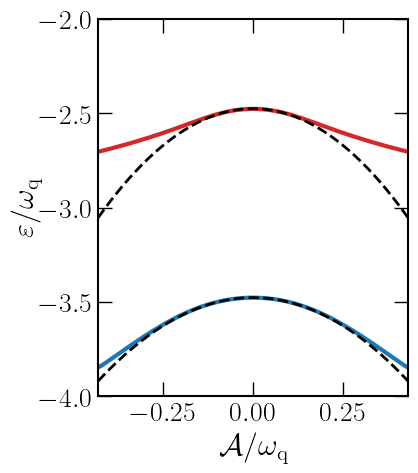

In [41]:
%matplotlib inline

fig, ax_replica = plt.subplots(figsize=(4,5), dpi=100)

cmap = mpl.colormaps["tab10"]
colors = [cmap.colors[0], cmap.colors[3], cmap.colors[4], cmap.colors[5]]

n_states_show = n_states

for ii,current_replica in enumerate(N_replicas):
    for n in range(n_states_show):
        if current_replica == 0:
            ax_replica.plot(A_list_replica/wq, evals_list[ii][:,n]/wq, c=colors[n], lw=3)
        else:
            ax_replica.plot(A_list_replica/wq, evals_list[ii][:,n]/wq, c=colors[n], lw=3, alpha=0.3)

    if device == 'transmon':
        ax_replica.plot(A_list_replica/wq, evals_floquet_analytical[:,0]/wq, c='black', ls='--', lw=2)
        ax_replica.plot(A_list_replica/wq, evals_floquet_analytical[:,1]/wq, c='black', ls='--', lw=2)

ax_replica.xaxis.set_tick_params(direction="in", which='both')
ax_replica.yaxis.set_tick_params(direction="in", which='both')
ax_replica.tick_params(top=True, bottom=True, left=True, right=True, labelleft=True,
                  labelbottom=True, labelright=False, labeltop=False, which='both')

ax_replica.set_xlabel(r'$\mathcal A/\omega_{\rm q}$')
ax_replica.set_ylabel(r'$\varepsilon/\omega_{\rm q}$', labelpad=-2)

ax_replica.set_ylim([-4,-2])

In [42]:
if save_file:
    fname = 'data/'+device+'/'+device+'_floquet_spectrum_w_r='+str(np.round(w_r/wq,3))

    if device == 'flopping_spin' or device == 'flopping_charge':
        np.savez(fname, A_list_replica=A_list_replica, wq=wq, w_r=w_r, evals_list=evals_list, N_replicas=N_replicas, color_m=color_m)
    else:
        np.savez(fname, A_list_replica=A_list_replica, wq=wq, w_r=w_r, evals_list=evals_list, N_replicas=N_replicas)